In [6]:
# Instalamos la librería rasterio
!pip install scikeo rasterio dbfread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 16.7 MB 57.4 MB/s 
  Created wheel for scikeo: filename=scikeo-0.1.9-py2.py3-none-any.whl size=33133 sha256=236b7f80816797ef52cb97339887c17659829b00451f73cb690b33fe8f812730
  Stored in directory: /root/.cache/pip/wheels/11/e9/f5/9e154aa8d4bf67ebad85bd6ecbb7d0b435f4ade574c3d9d63c
Successfully built scikeo


In [7]:
# Importamos librerías
import rasterio
import numpy as np
from scikeo.mla import MLA
from scikeo.plot import plotRGB
import matplotlib.pyplot as plt
from dbfread import DBF
import matplotlib as mpl
import pandas as pd

In [8]:
# Permitimos el acceso al contenido de nuestro Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
# Definimos el raster con la ruta que tiene en nuestro Drive
path_raster = "/content/drive/MyDrive/Facultad/10MO CICLO/Análisis Espacial/TA_Ancash/T18LTQ_20220826T152651_AOI.tif"

# Lo renombramos por practicidad
img = rasterio.open(path_raster)

# De igual manera para los puntos o end members
path_endm = "/content/drive/MyDrive/Facultad/10MO CICLO/Análisis Espacial/TA_Ancash/End_copy.dbf"
endm = DBF(path_endm)

In [37]:
# Se crea un Data Frame o tabla bidemensional que relaciona las distintas variables.
df = pd.DataFrame(iter(endm))
df.head()

,Class,b1_T18LTQ_,b2_T18LTQ_,b3_T18LTQ_,b4_T18LTQ_,b5_T18LTQ_,b6_T18LTQ_
0,1,1554,1406,1248,1187,1141,1109
1,1,1968,1708,1289,1164,1109,1108
2,1,1976,1728,1299,1164,1113,1103
3,1,1992,1722,1293,1161,1101,1116
4,1,2136,1715,1283,1182,1132,1126


In [38]:
# Verificación de Machine Learning
inst = MLA(image = img, endmembers = endm)

In [39]:
# Aplicación de Support Vector Machine con un entrenamiento del 50%
import warnings 
warnings.filterwarnings("ignore")

rf_class = inst.SVM(training_split = 0.5)

In [40]:
rf_class.keys()

dict_keys(['Overall_Accuracy', 'Kappa_Index', 'Confusion_Matrix', 'Classification_Map', 'Image'])

In [41]:
rf_class.get('Overall_Accuracy')

0.8273092369477911

In [42]:
rf_class.get('Kappa_Index')

0.7505958492738931

In [43]:
# Hallamos la matriz de confusión

rf_class.get('Confusion_Matrix')

,0,1,2,3,4,5,6,Total,Users_Accuracy,Commission
0,60.000000,1.0,2.000000,0.000000,0.0,0.000000,2.000000,65.0,92.307692,7.692308
1,0.000000,96.0,0.000000,9.000000,0.0,1.000000,0.000000,106.0,90.566038,9.433962
2,1.000000,0.0,238.000000,18.000000,11.0,3.000000,1.000000,272.0,87.500000,12.500000
3,11.000000,2.0,19.000000,527.000000,35.0,48.000000,27.000000,669.0,78.774290,21.225710
4,0.000000,0.0,8.000000,1.000000,72.0,4.000000,1.000000,86.0,83.720930,16.279070
5,0.000000,1.0,0.000000,5.000000,2.0,23.000000,0.000000,31.0,74.193548,25.806452
6,1.000000,0.0,0.000000,1.000000,0.0,0.000000,14.000000,16.0,87.500000,12.500000
Total,73.000000,100.0,267.000000,561.000000,120.0,79.000000,45.000000,NaN,NaN,NaN
Producer_Accuracy,82.191781,96.0,89.138577,93.939394,60.0,29.113924,31.111111,NaN,NaN,NaN
Omission,17.808219,4.0,10.861423,6.060606,40.0,70.886076,68.888889,NaN,NaN,NaN


In [44]:
# Conversion a formato array
arr_img = img.read()

# Unir las capas de la imagen
rgb = np.stack([arr_img[4,:,:], arr_img[3,:,:], arr_img[2,:,:]], axis = -1)

# Definición de los colores
palette = mpl.colors.ListedColormap(["#2232F9","#F922AE","#229954","#7CED5E"])

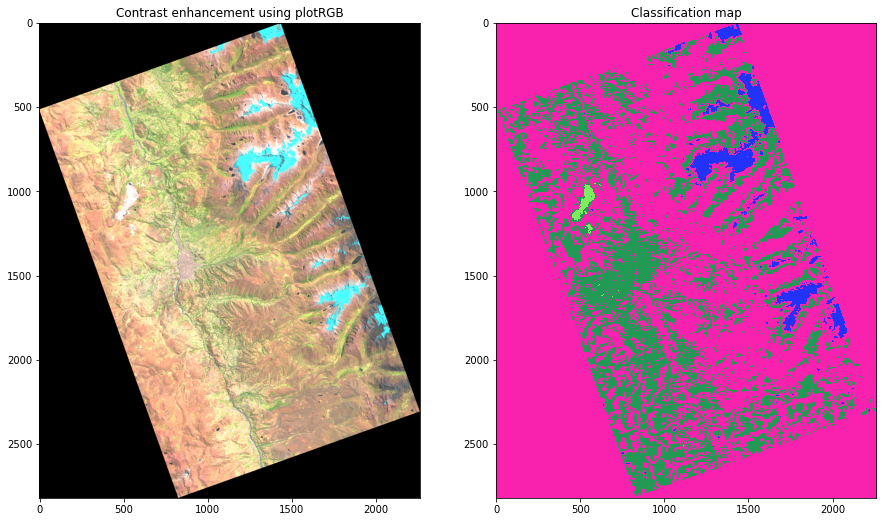

In [45]:
# Ploteo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 9))

# Imagen satelital
plotRGB(img, title = 'Contrast enhancement using plotRGB', ax = axes[0])

# Resultados
axes[1].imshow(rf_class.get('Classification_Map'), cmap = palette)
axes[1].set_title("Classification map")
axes[1].grid(False)

In [46]:
# Importar a formato raster
from scikeo.writeRaster import writeRaster

In [47]:
# Guardar resultados
writeRaster(arr = rf_class.get('Classification_Map'), 
   image = img, 
   filename = 'T18LTQ_20220826T152651_AOI_CLASS', 
   filepath = '/content/drive/MyDrive/Facultad/10MO CICLO/Análisis Espacial/TA_Ancash',
   n = 1)